# **Step 1: Notebook to Create ML Model**

---


### **Import Libraries**

Chat GPT an copilot was used, it was use to understand and implement adaboost and voting classifier as well as calculating f scores and weighting them and remake the values 1,2,3 to normal suspect and pathalogical

In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn

# Package to implement Decision Tree Model
import sklearn
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import f1_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Module to save and load Python objects to and from files
import pickle 

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

%matplotlib inline

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

### **Load Dataset as DataFrame**

In [2]:
apartment_df = pd.read_csv('apartments_sweden.csv')

apartment_df.head()

,latitude,longitude,location_area,number_of_rooms,area,rent,floor,has_elevator,has_fireplace,has_outside,sold_price,adress
0,59.330912,18.005707,Fredhäll,2.0,34.0,"2,172",2.0,no,NaN,NaN,3180000,Adlerbethsgatan 15
1,59.330912,18.005707,Fredhäll,1.5,34.0,"2,259",2.0,no,NaN,NaN,3240000,Adlerbethsgatan 15
2,59.330912,18.005707,Fredhäll,1.0,34.0,"2,259",3.0,no,no,no,3200000,Adlerbethsgatan 15
3,59.330912,18.005707,Fredhäll,2.0,34.0,"2,259",3.0,no,no,no,3250000,Adlerbethsgatan 15
4,59.330912,18.005707,Fredhäll,2.0,47.0,"3,078",3.0,no,NaN,yes,4710000,Adlerbethsgatan 15


In [3]:
# Dropping null values
apartment_df.dropna(inplace = True)
apartment_df.info()

# Remove rows where floor level is above 10
apartment_df = apartment_df[apartment_df['floor'] <= 10]

# Remove commas from rent column and convert to float
apartment_df['rent'] = apartment_df['rent'].str.replace(',', '').astype(float)


<class 'pandas.core.frame.DataFrame'>
Index: 4989 entries, 2 to 10046
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         4989 non-null   float64
 1   longitude        4989 non-null   float64
 2   location_area    4989 non-null   object 
 3   number_of_rooms  4989 non-null   float64
 4   area             4989 non-null   float64
 5   rent             4989 non-null   object 
 6   floor            4989 non-null   float64
 7   has_elevator     4989 non-null   object 
 8   has_fireplace    4989 non-null   object 
 9   has_outside      4989 non-null   object 
 10  sold_price       4989 non-null   int64  
 11  adress           4989 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 506.7+ KB


In [4]:
# Distribution of price column
#Dont need this?
apartment_df['sold_price'].value_counts(normalize = True)

sold_price
4300000    0.010303
3100000    0.009899
4600000    0.008889
3800000    0.008889
3900000    0.008889
             ...   
7765000    0.000202
4780000    0.000202
5515000    0.000202
9130000    0.000202
5930000    0.000202
Name: proportion, Length: 948, dtype: float64

### **Select Input and Output Features**

In [5]:
# Output column for prediction
output = apartment_df['sold_price'] 

features = apartment_df[[
    "latitude",
    "longitude",
    "location_area",
    "number_of_rooms",
    "area",
    "rent",
    "floor",
    "has_elevator",
    "has_fireplace",
    "has_outside",
    "adress",
]]


In [6]:
# Store latitude and longitude separately for geospatial analysis later
location_data = features[['latitude', 'longitude']].copy()  
# Remove latitude and longitude from features for prediction
features = features.drop(['latitude', 'longitude'], axis=1)

adresses = features['adress']
features = features.drop(['adress'], axis=1)

# One-hot encode categorical variables
features_encoded = pd.get_dummies(features, columns=[
    'location_area',
    'number_of_rooms',
    'floor',            
    'has_elevator',
    'has_fireplace',
    'has_outside'
])

features_encoded.head()

,area,rent,location_area_Fredhäll,location_area_Gamla Stan,location_area_Gärdet,location_area_Hammarby sjöstad,location_area_Hjorthagen,location_area_Kristineberg,location_area_Kungsholmen,location_area_Lilla Essingen,...,floor_7.0,floor_8.0,floor_9.0,floor_10.0,has_elevator_no,has_elevator_yes,has_fireplace_no,has_fireplace_yes,has_outside_no,has_outside_yes
2,34.0,2259.0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,34.0,2259.0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
5,45.0,2835.0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
7,34.0,2190.0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
9,34.0,2172.0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False


In [7]:
# save features_encoded and output to csv for use in other notebooks
features_encoded.to_csv('features_encoded.csv', index=False)


### **Data Partitioning**

In [8]:
train_X, test_X, train_y, test_y = train_test_split(features_encoded, output, test_size = 0.2, random_state = 1) 

- `test_size`: Amount of data to be used for testing.

- `random_state`: Sets a seed for random number generation, ensuring the split is reproducible (same train/test sets every time you run it)

## **Prediction Modeling using Decision Tree and Random Forest**

In [9]:
# Defining prediction model
clf = DecisionTreeRegressor(random_state = 0)

# Fitting model on training data
clf.fit(train_X, train_y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [10]:
rnd = RandomForestRegressor(n_estimators = 100, random_state = 0)
rnd.fit(train_X, train_y)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
ada = AdaBoostRegressor(random_state=0)

# Fit the model on training data
ada.fit(train_X, train_y)

,estimator,None
,n_estimators,50
,learning_rate,1.0
,loss,'linear'
,random_state,0


### **Visualizing Trained Model**

**Choosing Colormaps in Matplotlib**: [**Check this link**](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

#### **Feature Importance Analysis**

It helps answer questions like:
**“Which features are most important in determining the output?”**

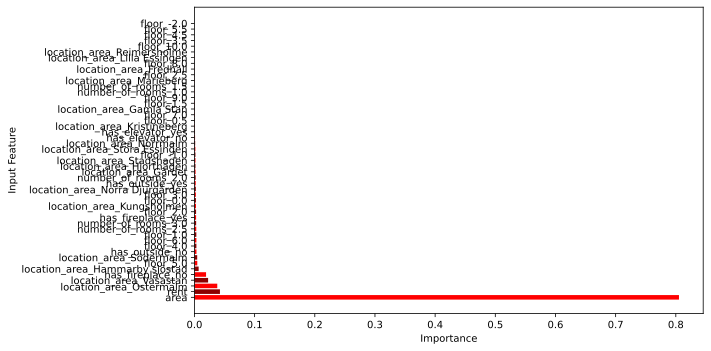

In [12]:
# Storing importance values from the trained model
importance = clf.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize = (10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['Red', 'Darkred'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.tight_layout()
plt.savefig("feature_imp_dt.svg")


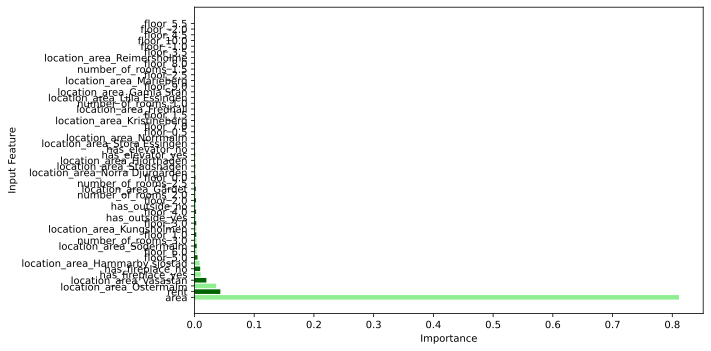

In [13]:
# Storing importance values from the trained model
importance = rnd.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize = (10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['Lightgreen', 'Darkgreen'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.tight_layout()
plt.savefig("feature_imp_rf.svg")

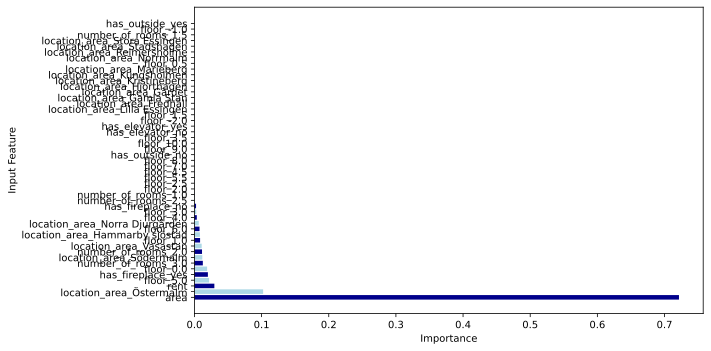

In [14]:
importance = ada.feature_importances_

# Store as a DataFrame
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
                           columns=['Feature', 'Importance'])

# Sort by importance (descending)
feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color=['Darkblue', 'Lightblue'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.tight_layout()

# Save as SVG
plt.savefig("feature_imp_ada.svg", bbox_inches='tight')

#### **Pred vs actual**

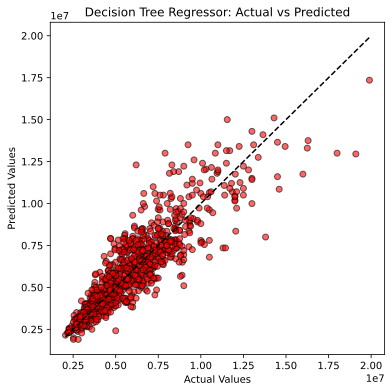

In [15]:
# Make predictions
y_pred_clf = clf.predict(test_X)

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_pred_clf, alpha=0.6, edgecolors='k', color='red')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'k--')  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree Regressor: Actual vs Predicted")

plt.savefig("actual_vs_predicted_dt.svg", bbox_inches='tight')

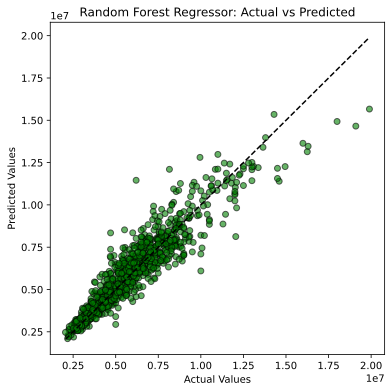

In [16]:
# Make predictions
y_pred_rnd = rnd.predict(test_X)

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_pred_rnd, alpha=0.6, edgecolors='k', color='green')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'k--')  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regressor: Actual vs Predicted")

plt.savefig("actual_vs_predicted_rf.svg", bbox_inches='tight')

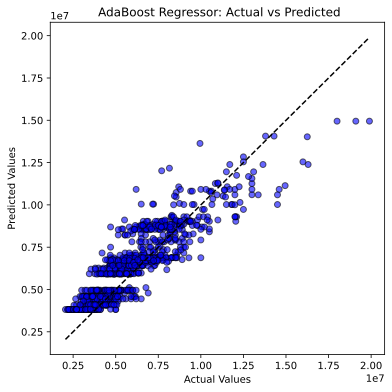

In [17]:
# Make predictions
y_pred_ada = ada.predict(test_X)

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_pred_ada, alpha=0.6, edgecolors='k', color='blue')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'k--')  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(" AdaBoost Regressor: Actual vs Predicted")

plt.savefig("actual_vs_predicted_ada.svg", bbox_inches='tight')

#### **Histogram Plot**

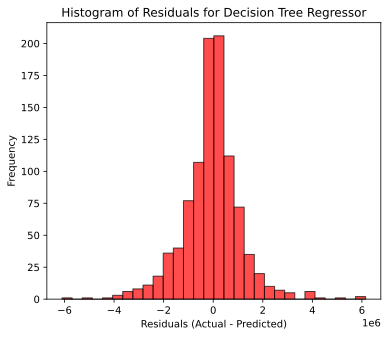

In [18]:
# Predictions
y_pred_clf = clf.predict(test_X)

# Residuals
residuals = test_y - y_pred_clf

# Create histogram of residuals
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='red')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals for Decision Tree Regressor")
plt.savefig("residuals_hist_dt.svg", bbox_inches='tight')

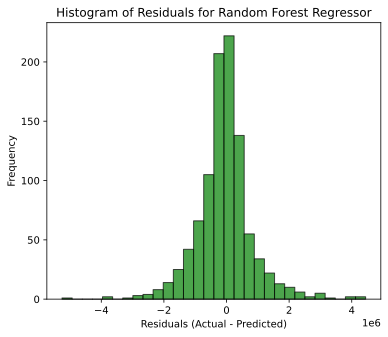

In [19]:
# Predictions
y_pred_rf = rnd.predict(test_X)

# Residuals
residuals = test_y - y_pred_rf

# Create histogram of residuals
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='green')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals for Random Forest Regressor")
plt.savefig("residuals_hist_rf.svg", bbox_inches='tight')

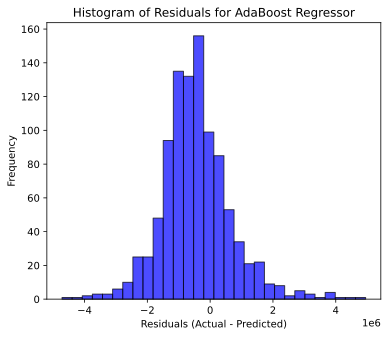

In [20]:
# Predictions
y_pred_ada = ada.predict(test_X)

# Residuals
residuals = test_y - y_pred_ada

# Create histogram of residuals
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='blue')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals for AdaBoost Regressor")
plt.savefig("residuals_hist_ada.svg", bbox_inches='tight')

### **Voting Regressor**


In [21]:
# Calculate R² scores (coefficient of determination) for regression
from sklearn.metrics import r2_score

r2_dt = r2_score(test_y, y_pred_clf)
r2_rf = r2_score(test_y, y_pred_rnd)
r2_ada = r2_score(test_y, y_pred_ada)

print("R² Scores:")
print(f"Decision Tree: {r2_dt:.4f}")
print(f"Random Forest: {r2_rf:.4f}")
print(f"AdaBoost: {r2_ada:.4f}")

# Combine R² scores
scores = np.array([r2_dt, r2_rf, r2_ada])

# Normalize
weights = scores / scores.sum()
print("Normalized Weights:", weights)

R² Scores:
Decision Tree: 0.7875
Random Forest: 0.8787
AdaBoost: 0.7791
Normalized Weights: [0.3220439  0.35934536 0.31861075]


In [22]:
# Calculate F1 scores for use in cell 37 (converting regression to classification for F1)
from sklearn.metrics import mean_squared_error
mse_dt = mean_squared_error(test_y, y_pred_clf)
mse_rf = mean_squared_error(test_y, y_pred_rnd)
mse_ada = mean_squared_error(test_y, y_pred_ada)

# Convert MSE to a score (lower MSE = higher score)
f1_dt = 1 / (1 + mse_dt)
f1_rf = 1 / (1 + mse_rf)
f1_ada = 1 / (1 + mse_ada)

# Create the VotingRegressor (no 'voting' parameter needed)
voting = VotingRegressor(
    estimators=[
        ('DecisionTree', clf),
        ('RandomForest', rnd),
        ('AdaBoost', ada)
    ],
    weights=weights
)

voting.fit(train_X, train_y)


,estimators,"[('DecisionTree', ...), ('RandomForest', ...), ...]"
,weights,"array([0.3220..., 0.31861075])"
,n_jobs,None
,verbose,False
,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None


Normalized F1 Weights: [0.26925004 0.47173257 0.2590174 ]


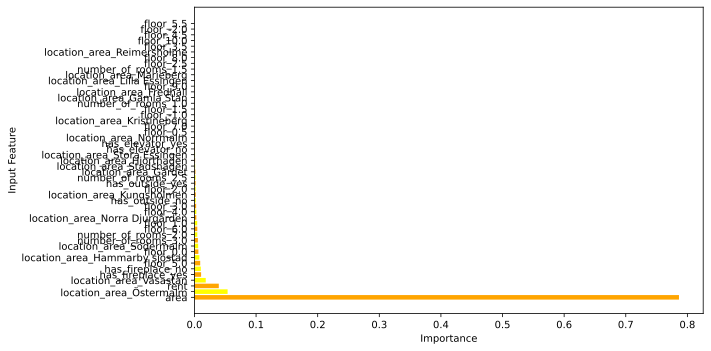

In [23]:

imp_dt = clf.feature_importances_
imp_rf = rnd.feature_importances_
imp_ada = ada.feature_importances_

scores = np.array([f1_dt, f1_rf, f1_ada], dtype=float)
weights = scores / scores.sum()

print("Normalized F1 Weights:", weights)

weighted_importance = (
    weights[0] * imp_dt +
    weights[1] * imp_rf +
    weights[2] * imp_ada
)

feature_imp = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': weighted_importance
}).sort_values('Importance', ascending=False).reset_index(drop=True)


feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color=['Orange', 'Yellow'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.tight_layout()

# Save as SVG
plt.savefig("feature_imp_vote.svg", bbox_inches='tight')


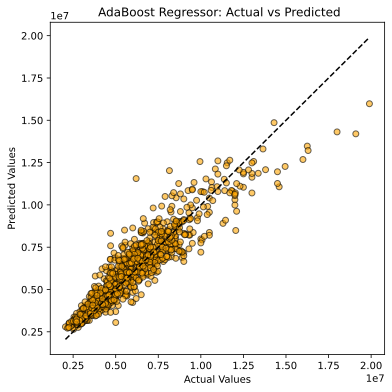

In [24]:
# Make predictions
y_pred_vote = voting.predict(test_X)

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(test_y, y_pred_vote, alpha=0.6, edgecolors='k', color='orange')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'k--')  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(" AdaBoost Regressor: Actual vs Predicted")

plt.savefig("actual_vs_predicted_vote.svg", bbox_inches='tight')

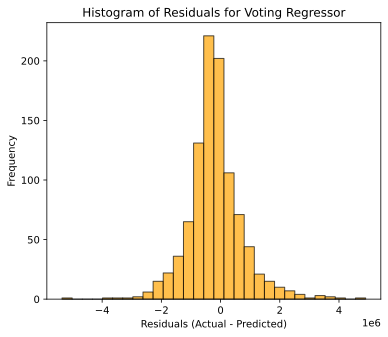

In [25]:
# Predictions
y_pred_vote = voting.predict(test_X)

# Residuals
residuals = test_y - y_pred_vote

# Create histogram of residuals
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='orange')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals for Voting Regressor")
plt.savefig("residuals_hist_vote.svg", bbox_inches='tight')

# MAPIE regressor


# Decision Tree

In [26]:
# Define MAPIE regressor
mapie_dt = MapieRegressor(estimator = clf, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
mapie_dt.fit(train_X, train_y)
     
alpha = 0.1 # For 90% confidence level
# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie_dt.predict(test_X, alpha = alpha)

In [27]:
predictions_dt = test_y.to_frame()
predictions_dt.columns = ['Actual Value']
predictions_dt["Predicted Value"] = y_test_pred.round(2)
predictions_dt["Lower Value"] = y_test_pis[:, 0].round(2)
predictions_dt["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions_dt.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
9341,4400000,5500000.0,2625000.0,6850000.0
2816,3900000,4450000.0,2625000.0,6550000.0
6922,5800000,4775000.0,3070000.0,7050000.0
3959,3510000,3415000.0,1525000.0,5415000.0
1710,4600000,5625000.0,2975000.0,7065000.0


Coverage: 96.67%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


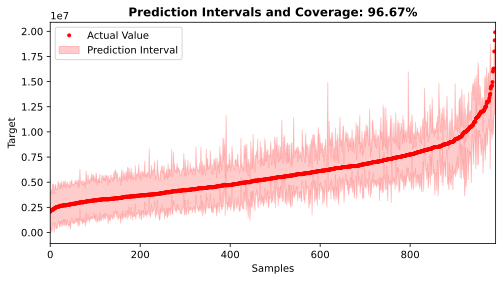

In [28]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions_dt.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with red dots
plt.plot(sorted_predictions["Actual Value"], 'ro', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent red color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="red", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("prediction_intervals_dt.svg", bbox_inches='tight')

# Random Forest

In [29]:
# Define MAPIE regressor
mapie_rf = MapieRegressor(estimator = rnd, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
mapie_rf.fit(train_X, train_y)
     
alpha = 0.1 # For 90% confidence level
# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie_rf.predict(test_X, alpha = alpha)

In [30]:
predictions_rf = test_y.to_frame()
predictions_rf.columns = ['Actual Value']
predictions_rf["Predicted Value"] = y_test_pred.round(2)
predictions_rf["Lower Value"] = y_test_pis[:, 0].round(2)
predictions_rf["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions_rf.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
9341,4400000,4965450.0,3446650.00,6264200.0
2816,3900000,4541700.0,3111500.14,5903120.0
6922,5800000,6042250.0,4580990.00,7459250.0
3959,3510000,3477900.0,2043850.00,4859520.0
1710,4600000,5269650.0,3808500.00,6631900.0


Coverage: 90.91%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


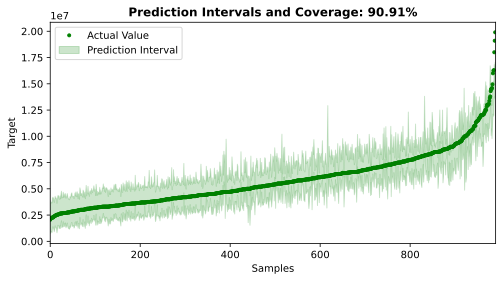

In [31]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions_rf.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("prediction_intervals_rf.svg", bbox_inches='tight')

In [32]:
# Define MAPIE regressor
mapie_ada = MapieRegressor(estimator = ada, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
mapie_ada.fit(train_X, train_y)
     
alpha = 0.1 # For 90% confidence level
# Use mapie.predict() to get predicted values and intervals
y_test_pred_ada, y_test_pis_ada = mapie_ada.predict(test_X, alpha = alpha)

In [33]:
predictions_ada = test_y.to_frame()
predictions_ada.columns = ['Actual Value']
predictions_ada["Predicted Value"] = y_test_pred.round(2)
predictions_ada["Lower Value"] = y_test_pis_ada[:, 0].round(2)
predictions_ada["Upper Value"] = y_test_pis_ada[:, 1].round(2)

# Take a quick look
predictions_ada.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
9341,4400000,4965450.0,2691527.70,6401113.43
2816,3900000,4541700.0,3298574.80,7080361.88
6922,5800000,6042250.0,5431646.11,9123464.40
3959,3510000,3477900.0,1972017.69,5706343.10
1710,4600000,5269650.0,3363159.07,7231667.09


Coverage: 90.30%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


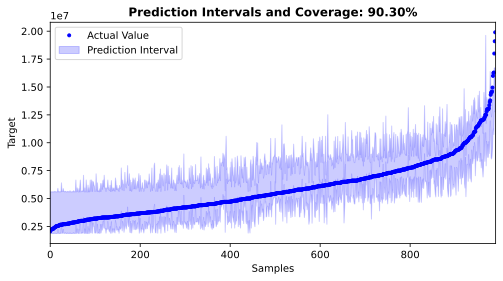

In [34]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis_ada[:, 0], # Lower bound of prediction intervals
                                     y_test_pis_ada[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions_ada.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with blue dots
plt.plot(sorted_predictions["Actual Value"], 'bo', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent blue color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="blue", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("prediction_intervals_ada.svg", bbox_inches='tight')

In [35]:
# Define MAPIE regressor
mapie_vote = MapieRegressor(estimator = voting, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
mapie_vote.fit(train_X, train_y)
     
alpha = 0.1 # For 90% confidence level
# Use mapie.predict() to get predicted values and intervals
y_test_pred_ada, y_test_pis_ada = mapie_vote.predict(test_X, alpha = alpha)

In [36]:
predictions_vote = test_y.to_frame()
predictions_vote.columns = ['Actual Value']
predictions_vote["Predicted Value"] = y_test_pred.round(2)
predictions_vote["Lower Value"] = y_test_pis_ada[:, 0].round(2)
predictions_vote["Upper Value"] = y_test_pis_ada[:, 1].round(2)

# Take a quick look
predictions_vote.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
9341,4400000,4965450.0,3185845.52,6283015.36
2816,3900000,4541700.0,3226216.79,6245619.55
6922,5800000,6042250.0,4597951.34,7622354.99
3959,3510000,3477900.0,2070659.26,5078665.18
1710,4600000,5269650.0,3647334.29,6655983.59


Coverage: 92.12%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


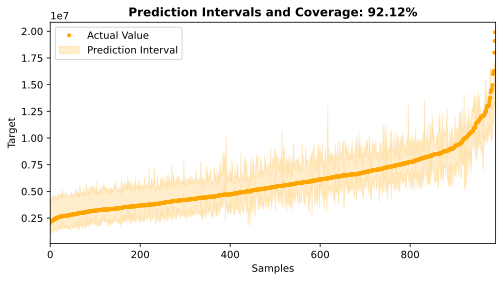

In [37]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis_ada[:, 0], # Lower bound of prediction intervals
                                     y_test_pis_ada[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions_vote.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with orange dots
plt.plot(sorted_predictions["Actual Value"], 'o', markersize=3, color='orange', label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent orange color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="orange", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig("prediction_intervals_vote.svg", bbox_inches='tight')

## **RMSE and R2 calculation**

In [38]:
# Get predictions for all models
y_pred_dt = clf.predict(test_X)
y_pred_rf = rnd.predict(test_X)
y_pred_ada = ada.predict(test_X)
y_pred_vote = voting.predict(test_X)

# Calculate R² scores
r2_dt = r2_score(test_y, y_pred_dt)
r2_rf = r2_score(test_y, y_pred_rf)
r2_ada = r2_score(test_y, y_pred_ada)
r2_vote = r2_score(test_y, y_pred_vote)

# Calculate RMSE scores
rmse_dt = np.sqrt(mean_squared_error(test_y, y_pred_dt))
rmse_rf = np.sqrt(mean_squared_error(test_y, y_pred_rf))
rmse_ada = np.sqrt(mean_squared_error(test_y, y_pred_ada))
rmse_vote = np.sqrt(mean_squared_error(test_y, y_pred_vote))

# Display results
print("Model Performance Comparison:")
print("=" * 50)
print(f"Decision Tree    - R²: {r2_dt:.4f}, RMSE: {rmse_dt:.2f}")
print(f"Random Forest    - R²: {r2_rf:.4f}, RMSE: {rmse_rf:.2f}")
print(f"AdaBoost         - R²: {r2_ada:.4f}, RMSE: {rmse_ada:.2f}")
print(f"Voting Regressor - R²: {r2_vote:.4f}, RMSE: {rmse_vote:.2f}")

# Save results as CSV, one per model
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'AdaBoost', 'Voting Regressor'],
    'R2 Score': [r2_dt, r2_rf, r2_ada, r2_vote],
    'RMSE': [rmse_dt, rmse_rf, rmse_ada, rmse_vote]
})
results_df.to_csv("model_performance.csv", index=False)

Model Performance Comparison:
Decision Tree    - R²: 0.7875, RMSE: 1178306.89
Random Forest    - R²: 0.8787, RMSE: 890201.60
AdaBoost         - R²: 0.7791, RMSE: 1201356.31
Voting Regressor - R²: 0.8630, RMSE: 945993.48


## **Save Your Prediction Model**

**Using Pickle**

 <img src="https://d33wubrfki0l68.cloudfront.net/0f66116c250285870171e38f309161bafc25f06b/dbd4c/assets/images/posts/pickled-cabbage.jpg" width="350" style="float: center"/>

**Pickle** is a useful Python tool that allows you to save your ML models, to minimise lengthy re-training and allow you to share, commit, and re-load pre-trained machine learning models.

In [39]:
models = {
    "Decision Tree": mapie_dt,
    "Random Forest": mapie_rf,
    "AdaBoost": mapie_ada,
    "Soft Voting": mapie_vote
}
for name, m in models.items():
    print(name, type(m))


# Save all models together in one pickle
with open('apartment_models.pickle', 'wb') as models_pickle:
    pickle.dump(models, models_pickle)


Decision Tree <class 'mapie.regression.regression.MapieRegressor'>
Random Forest <class 'mapie.regression.regression.MapieRegressor'>
AdaBoost <class 'mapie.regression.regression.MapieRegressor'>
Soft Voting <class 'mapie.regression.regression.MapieRegressor'>
